Procedo a analizar la relacion entre el codigo burocratico y si la operacion
es exitosa o no en base al porcentaje de closed Won sobre closed Lost.

In [156]:
import pandas as pd
import seaborn as sb

data = pd.read_csv('Entrenamieto_ECI_2020.csv')

data.drop_duplicates(subset=['Opportunity_ID'], inplace=True) #No cuento opportunities repetidos, el resultado igual es por opportunity
                                                                #y no por producto asi que no es que pierdo resultados
bureaucraticCode = data[['Bureaucratic_Code', 'Stage']]

bureaucraticCode = bureaucraticCode[bureaucraticCode['Stage'].isin(values=['Closed Won', 'Closed Lost'])]

bureaucraticCode.replace(to_replace=['Closed Won', 'Closed Lost'], value=[1, 0], inplace=True)

bureaucraticCode.replace(to_replace=['Bureaucratic_Code_0', 'Bureaucratic_Code_1', 'Bureaucratic_Code_2',
                                     'Bureaucratic_Code_3', 'Bureaucratic_Code_4',
                                     'Bureaucratic_Code_5', 'Bureaucratic_Code_6'],
                         value=['0', '1', '2', '3', '4', '5', '6'], inplace=True)

Analizo cuantos datos tengo de cada Bureaucratic Code para ver cuales considero
estadisticamente suficientes

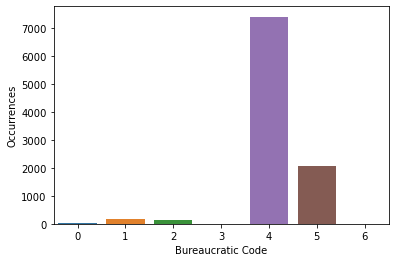

In [157]:
codesCount = bureaucraticCode.groupby('Bureaucratic_Code').agg({'Stage':'count'}).reset_index()
sb.barplot(x='Bureaucratic Code', y='Occurrences', data=(codesCount.rename(columns=
            {'Bureaucratic_Code':'Bureaucratic Code', 'Stage':'Occurrences'})))

Haciendo zoom en el Code 1 y Code 2

In [ ]:
sb.barplot(x='Bureaucratic Code', y='Occurrences', data=(codesCount.rename(columns=
            {'Bureaucratic_Code':'Bureaucratic Code', 'Stage':'Occurrences'})), order='15')

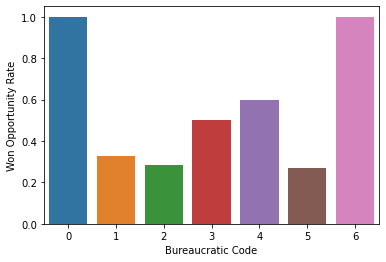

In [159]:
wonOpportunityRate = bureaucraticCode.groupby('Bureaucratic_Code').agg({'Stage':'mean'}).reset_index()

wonOpportunityRate.rename(columns={'Bureaucratic_Code':'Bureaucratic Code', 'Stage':'Won Opportunity Rate'}, inplace=True)

sb.barplot(x='Bureaucratic Code', y='Won Opportunity Rate', data=wonOpportunityRate)